In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.examples import clinic
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

# Clinic Example
![](img/clinic.png)

In [2]:
simulator = clinic.simulator

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/10

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[49], array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.42344354,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.51585521,   0.        ,
         4.34929369,   5.33611555,   4.79045358,  11.19269357,
        10.47966238,   6.52416327,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   5.97595535,   8.83547883,
         0.        ,   0.        ,   0.        ,   0.29101362,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ]), [964.8378133280579]]


In [4]:
closing_time, nr_patients, nr_waiting_patients = clinic.summaries

In [5]:
# prior over rate parameter
rate = pyabc.Prior('uniform', 0.01,1, name='rate')
rate.name

'rate'

# Our PYABC

In [6]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [7]:
rej.sample(nr_samples=1000, threshold=0.01)

Rejection sampler started with threshold: 0.01 and number of samples: 1000
Samples:   1000 - Threshold: 0.01 - Iterations:      25000 - Acceptance rate: 0.040000 - Time:    29.11 s


In [11]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [12]:
smc.sample(nr_samples=1000, thresholds=[0.1, 0.05, 0.01])

SMC sampler started with thresholds: [0.1, 0.05, 0.01] and number of samples: 1000
Rejection sampler started with threshold: 0.1 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
Samples:   1000 - Thresholds: 0.01 - Iterations:      11562 - Acceptance rate: 0.086490 - Time:    11.37 s


In [16]:
mcmc = pyabc.MCMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [17]:
mcmc.sample(nr_samples=1000, threshold=0.01, step_size = [0.01])

MCMC sampler started with threshold: 0.01 and number of samples: 1000
Rejection sampler started with threshold: 0.01 and number of samples: 10
Samples:   1000 - Threshold: 0.01 - Iterations:       5121 - Acceptance rate: 0.195274 - Time:     3.69 s


<IPython.core.display.Javascript object>


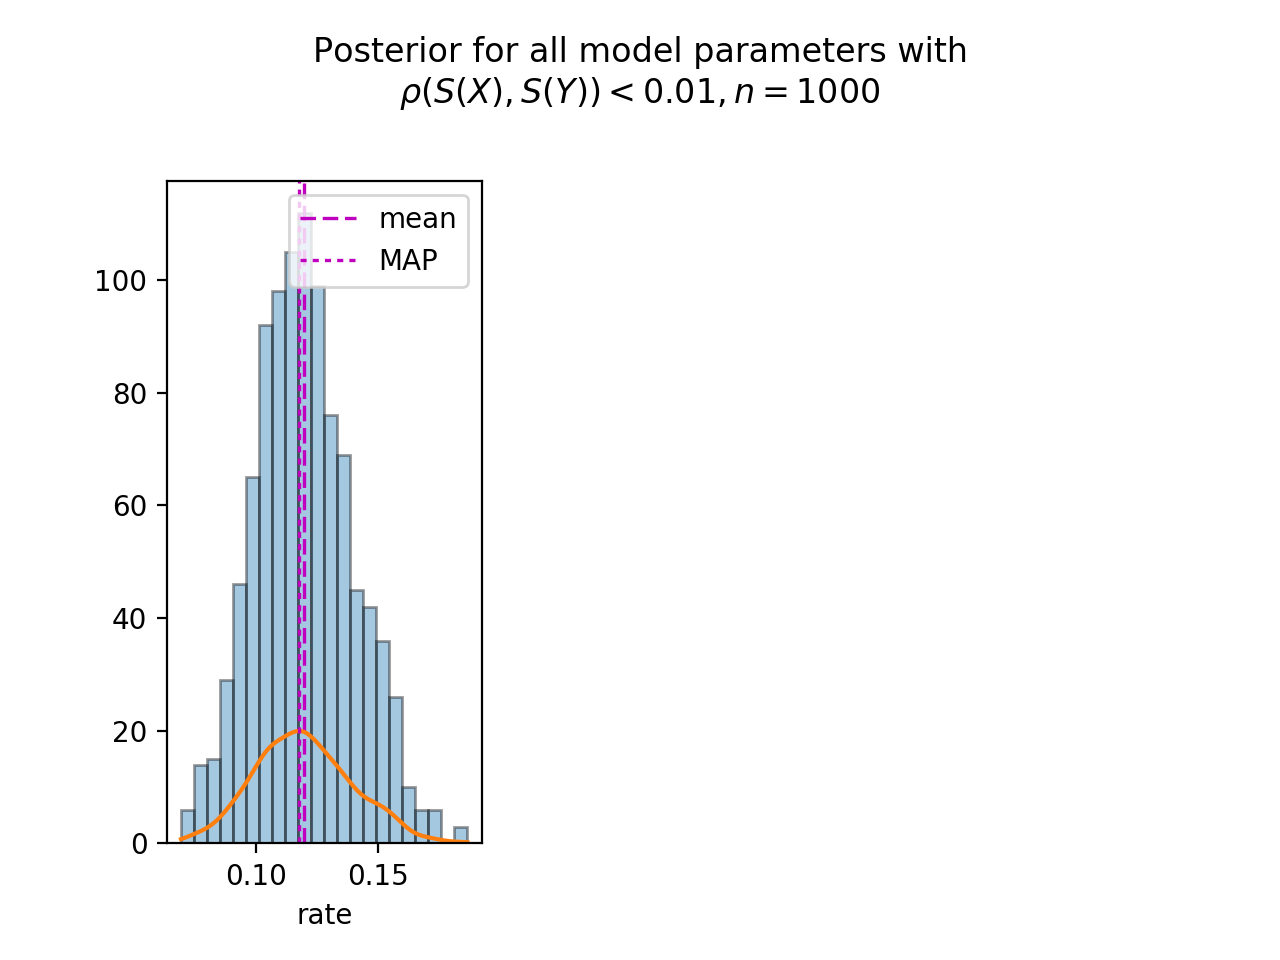

<IPython.core.display.Javascript object>


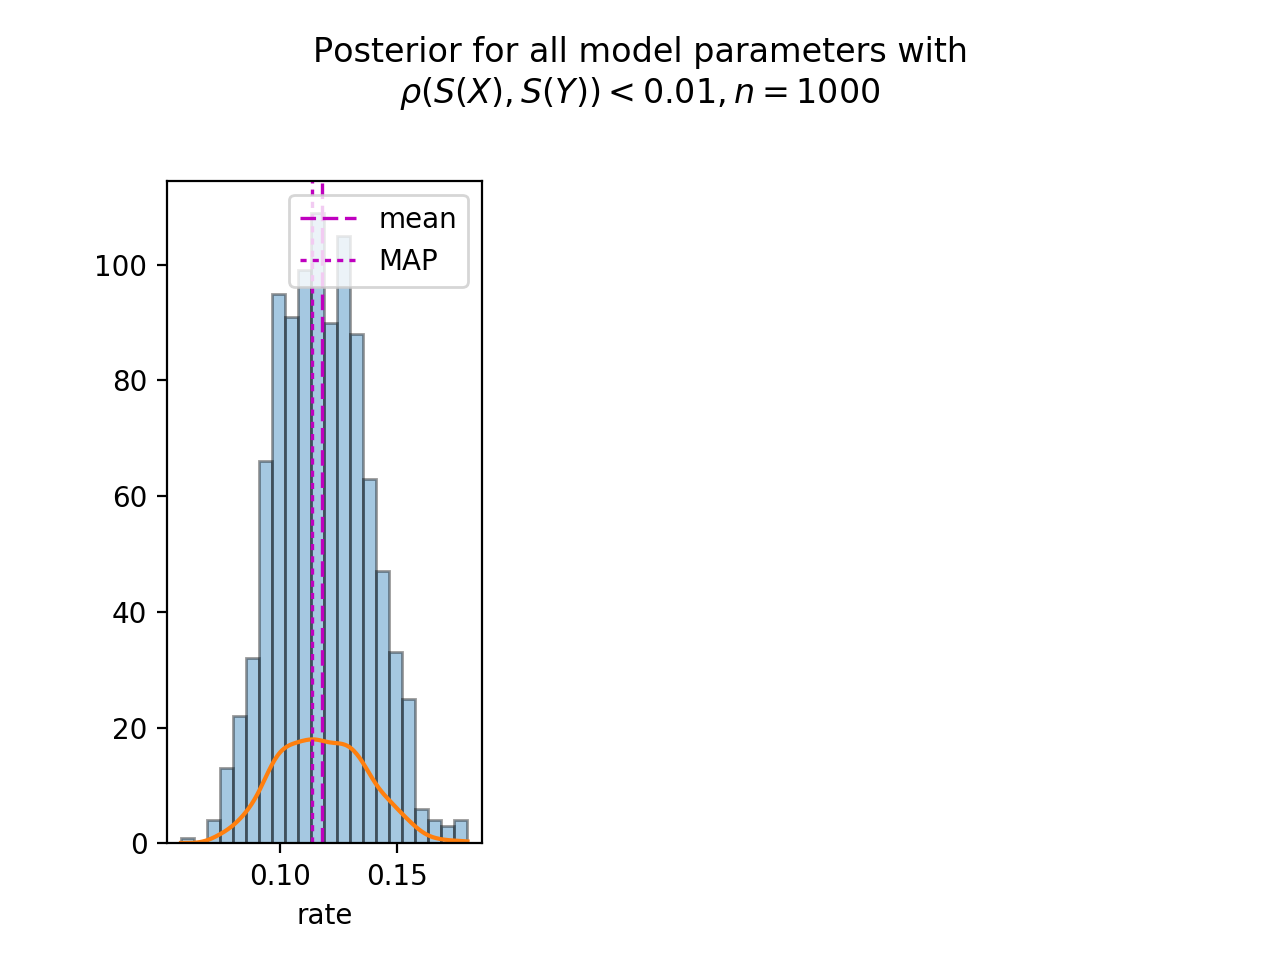

<IPython.core.display.Javascript object>


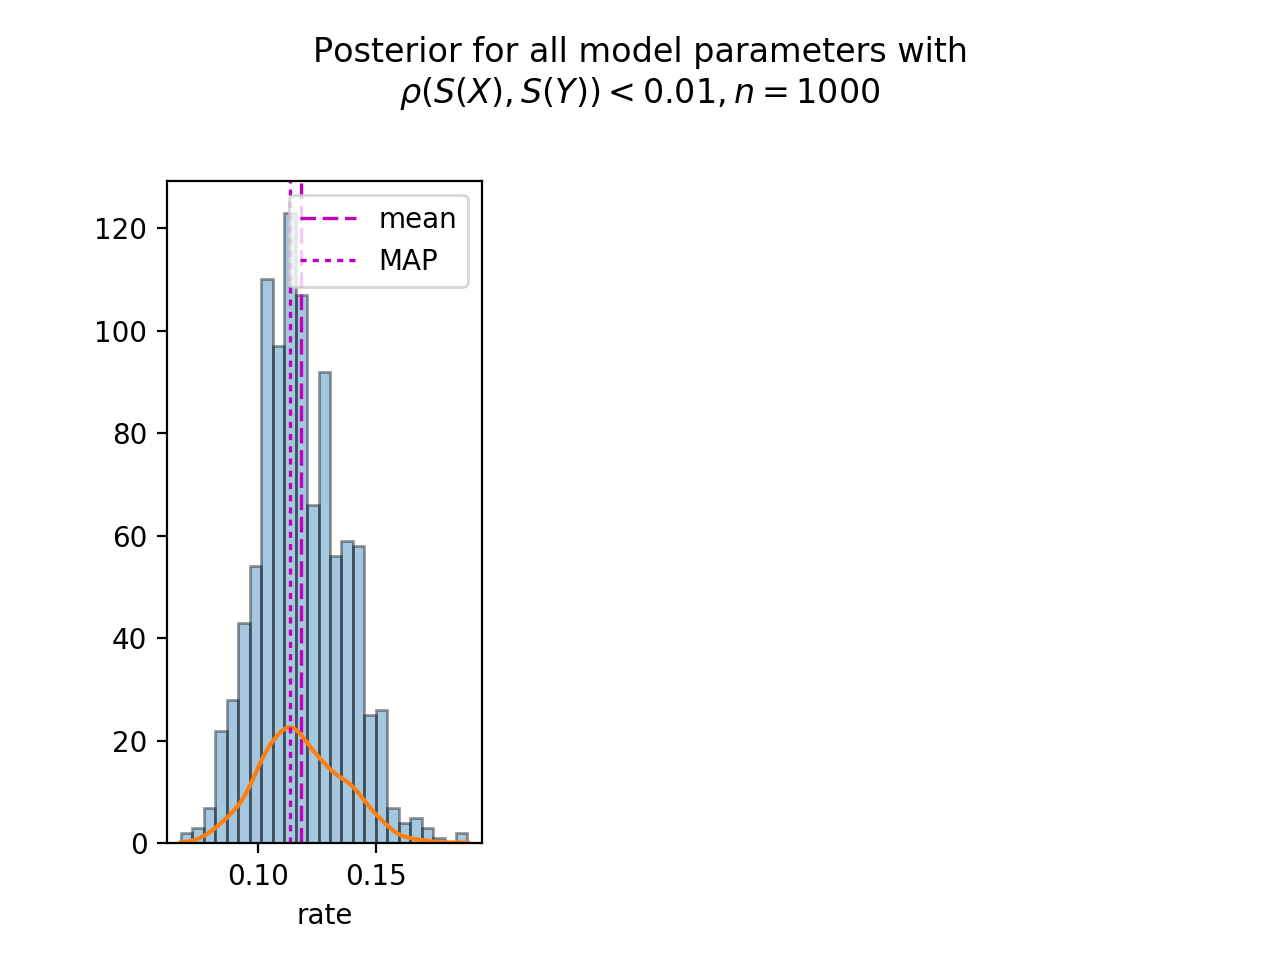

In [19]:
plot_marginals(rej, kde=True)
plot_marginals(smc, kde=True)
plot_marginals(mcmc, kde=True)

<IPython.core.display.Javascript object>


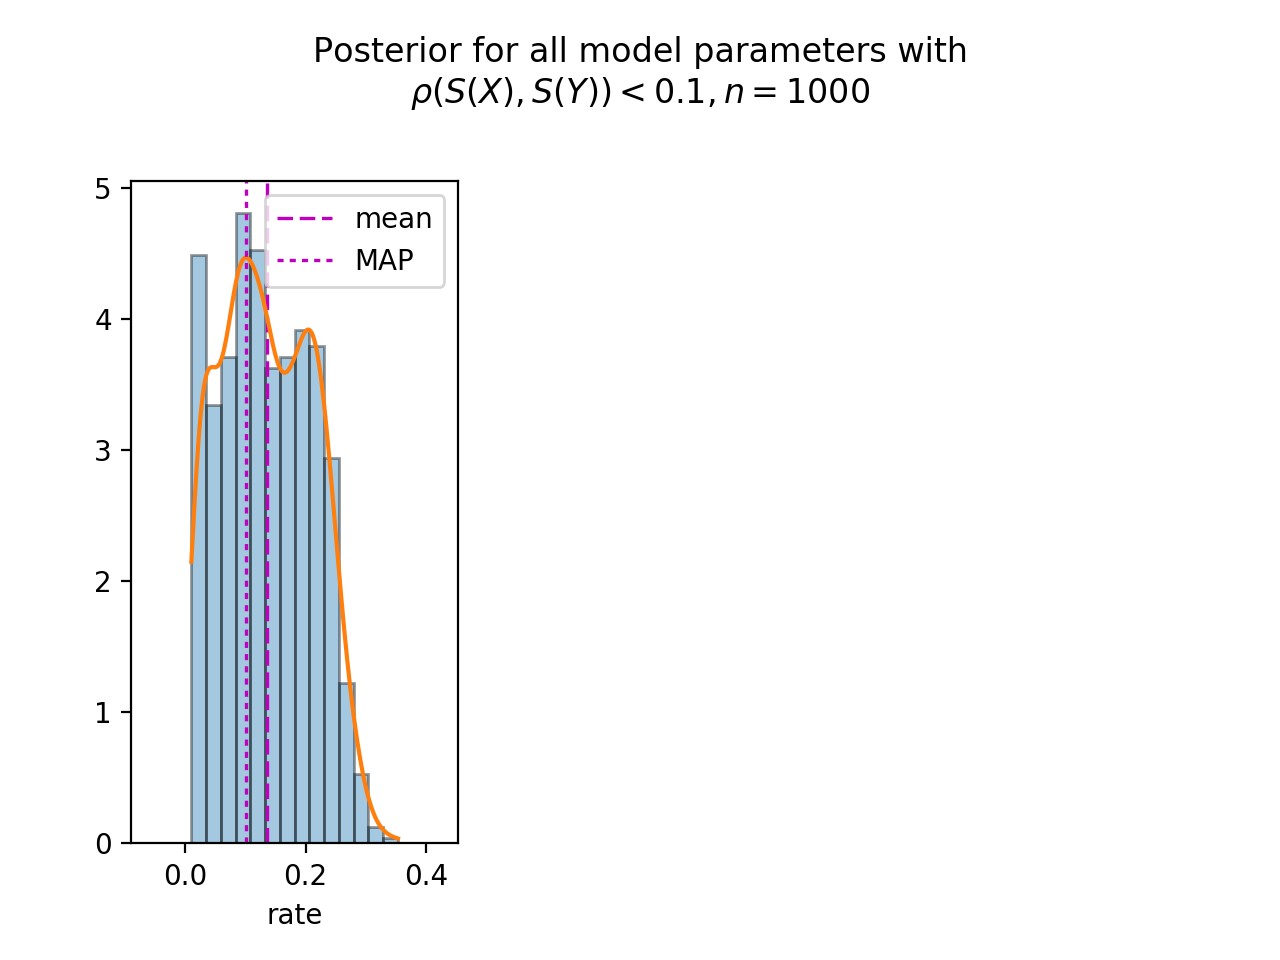

<IPython.core.display.Javascript object>


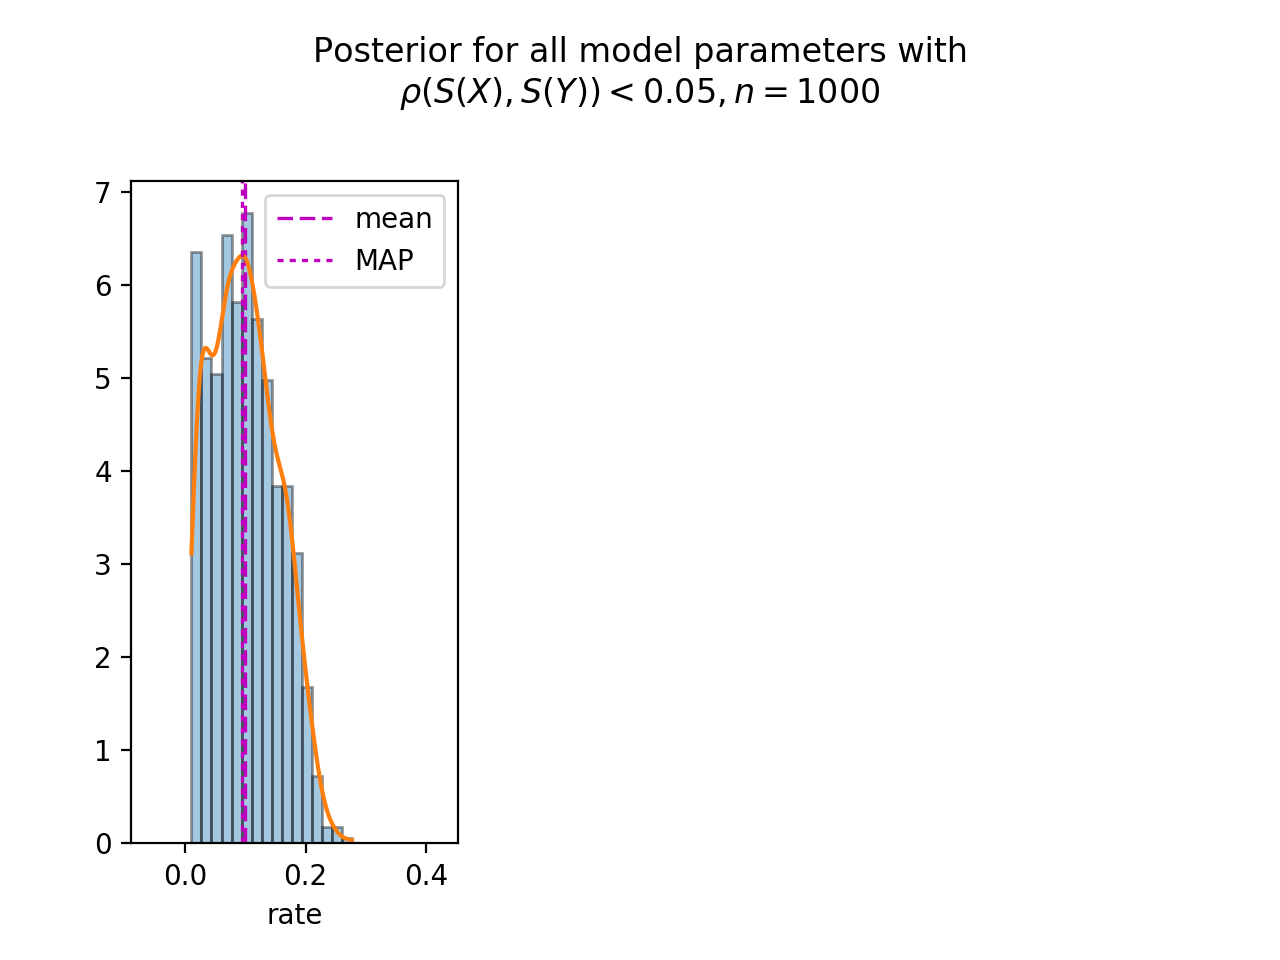

<IPython.core.display.Javascript object>


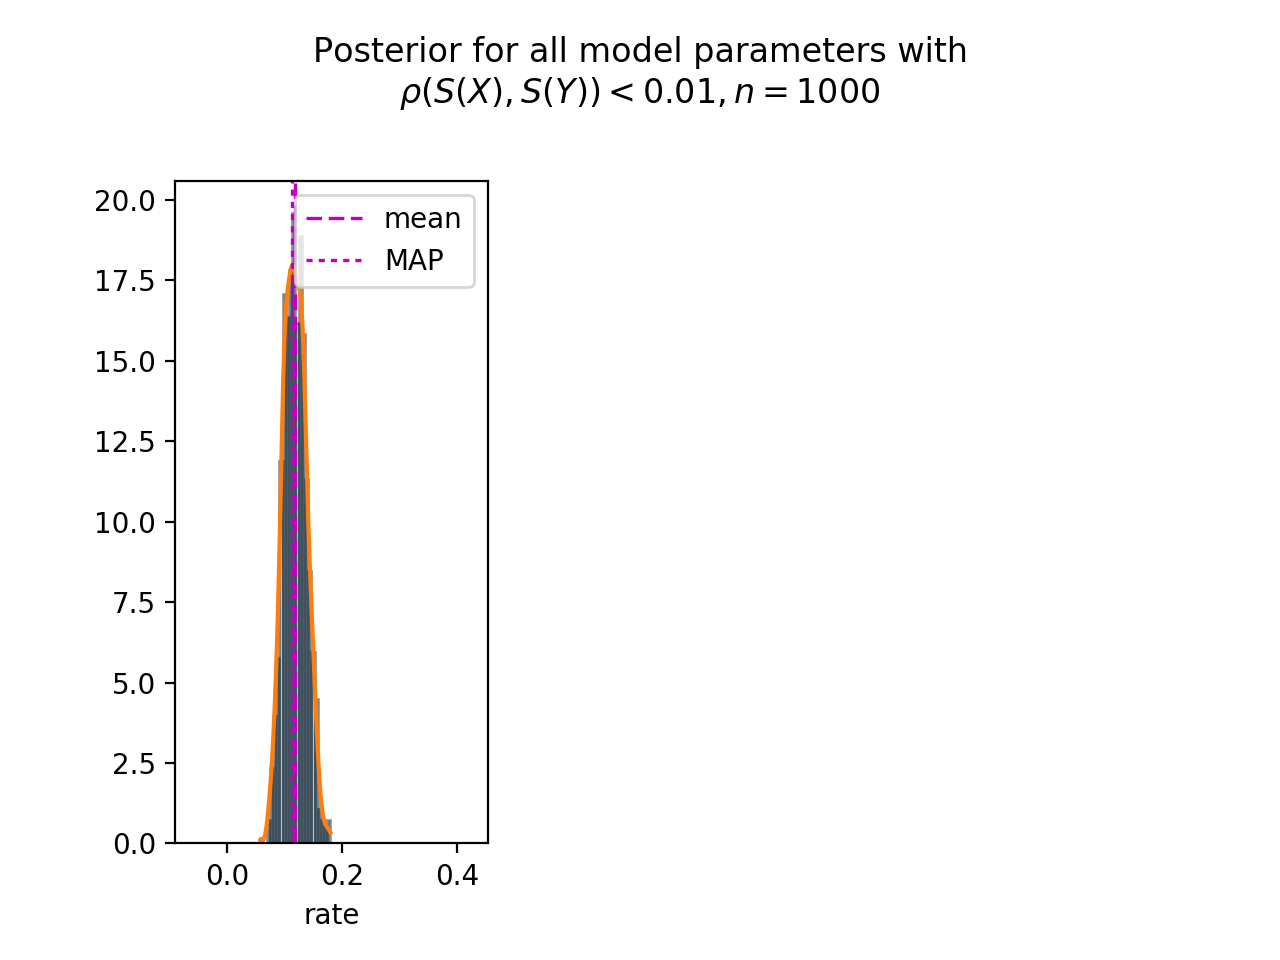

In [20]:
plot_marginals(smc, plot_all=True, normed=True, kde=True)

<IPython.core.display.Javascript object>


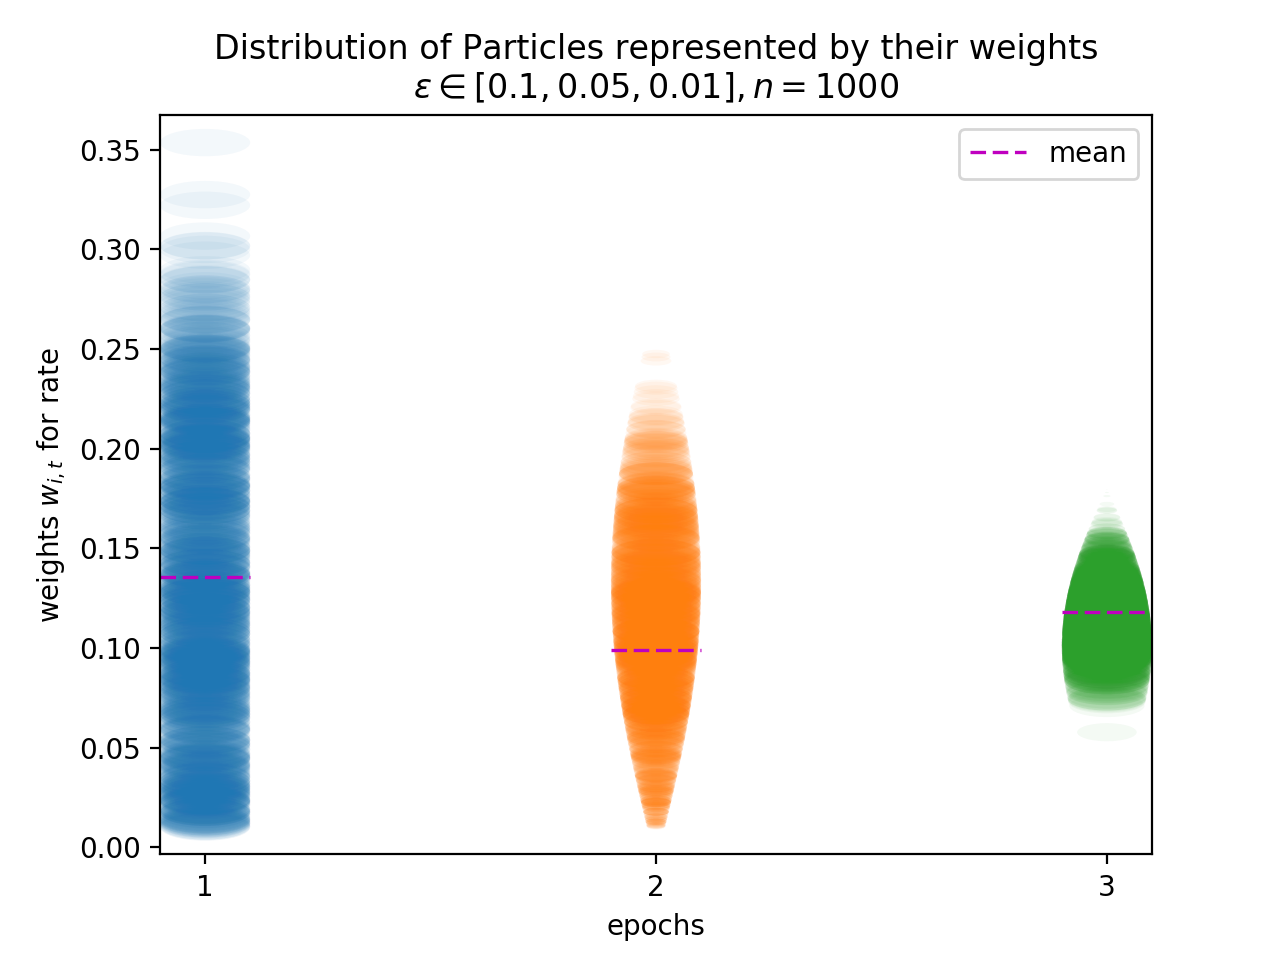

In [21]:
plot_particles(smc, equal_axes=False, alpha=0.05)

<IPython.core.display.Javascript object>


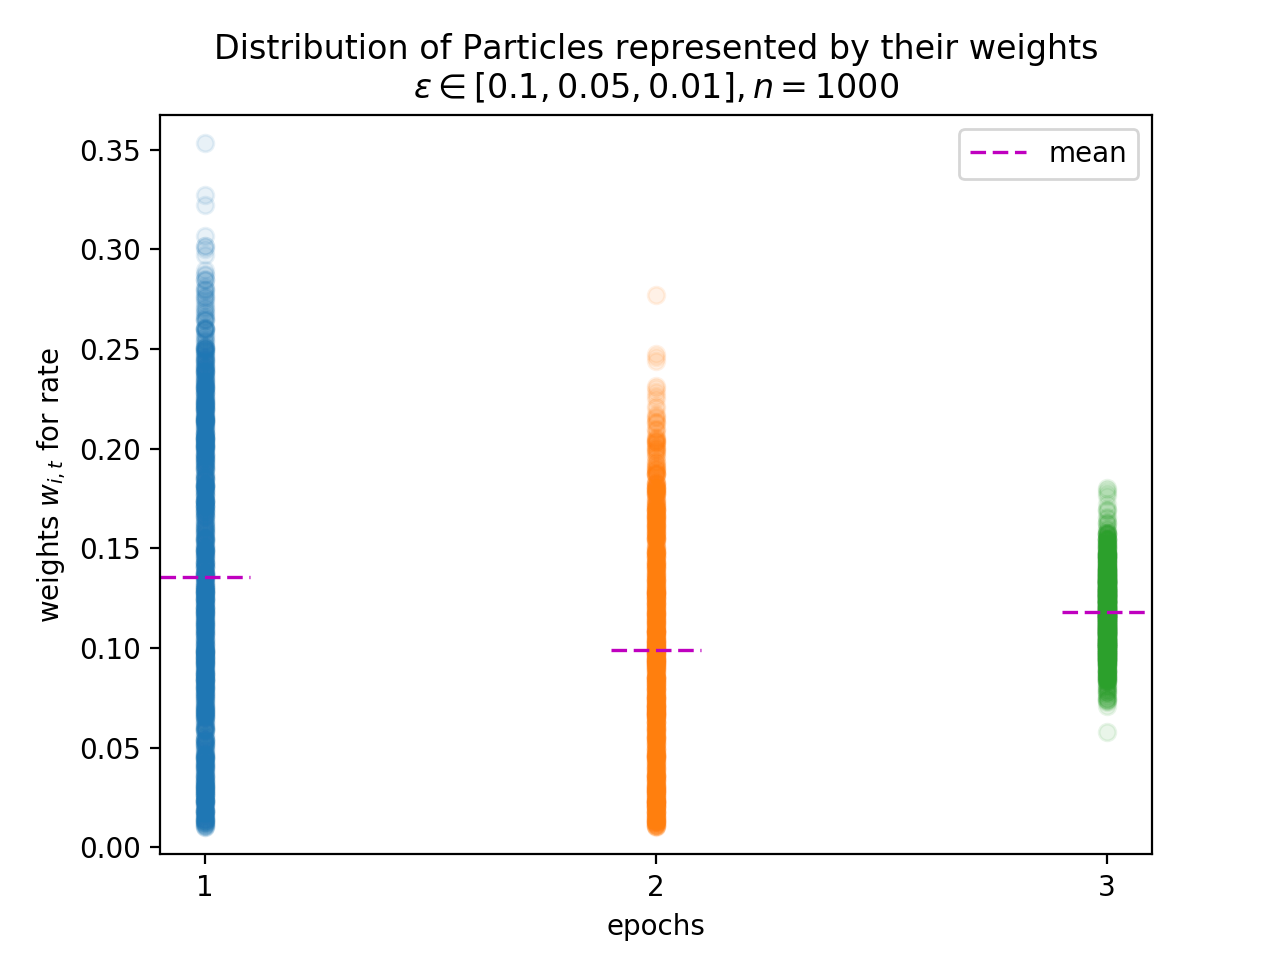

In [22]:
plot_particles(smc, as_circles=False, equal_axes=False, alpha=0.1)

<IPython.core.display.Javascript object>


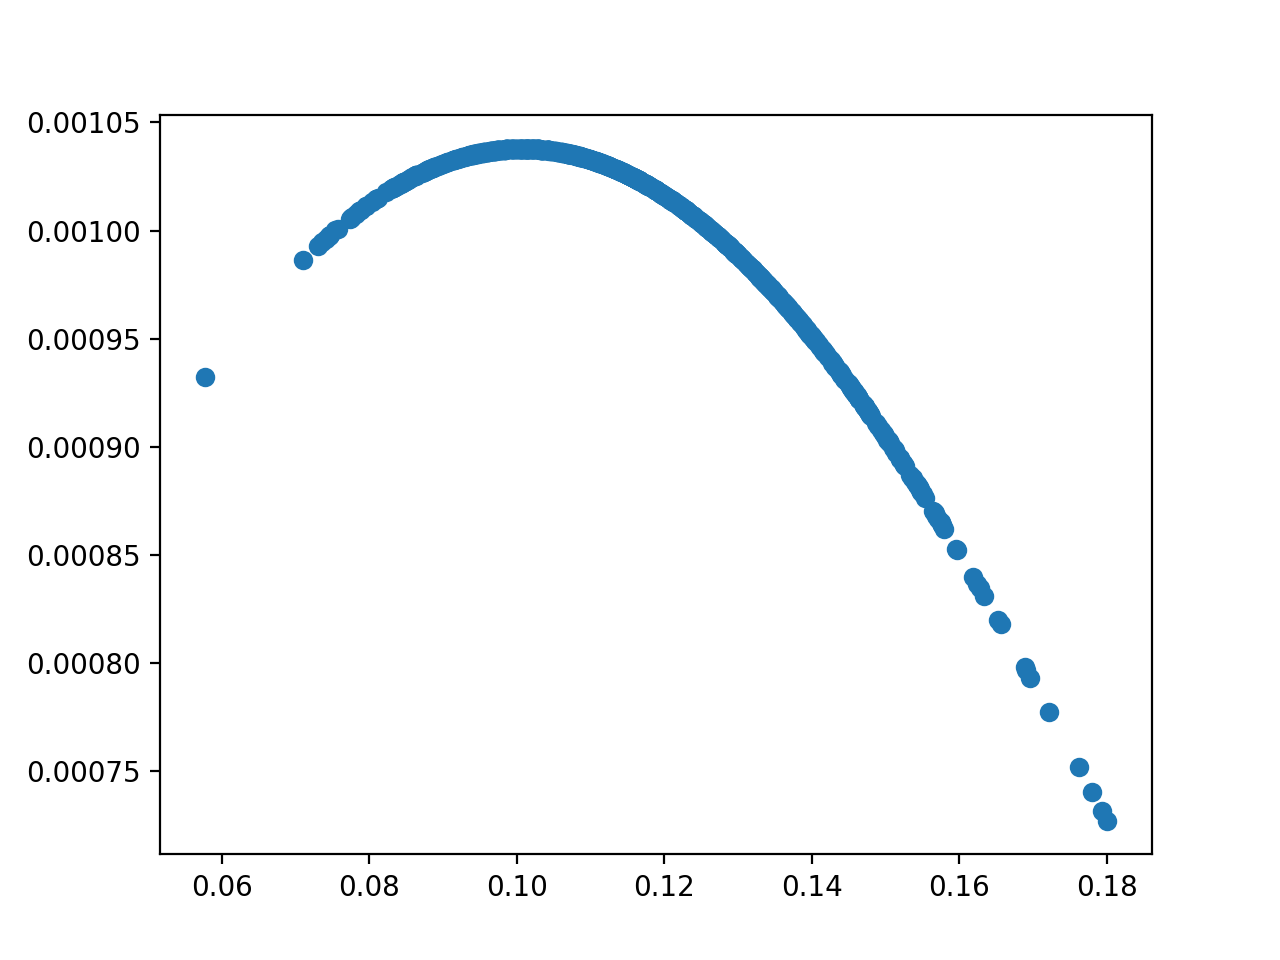

In [23]:
plt.figure()
plt.plot(smc.Thetas, smc.weights[-1], "o")